
# TFM — Predicción de salarios en Data Science
**Autor:** _Marcos Sanchez Pozo_  
**Máster:** UCM — Data Science, Big Data & Business Analytics  
**Objetivo:**   Analizar los salarios en el sector de la Ciencia de Datos utilizando un dataset de Kaggle, construir un modelo que estime el salario (€) a partir de características del puesto y contexto laboral. Se utilizarán técnicas de análisis exploratorio, preprocesado, modelado predictivo y visualización para alcanzar conclusiones orientadas a negocio.

## 0. Entorno, librerías y configuración

In [17]:

# Configuración básica
RANDOM_STATE = 42

# Librerías
import os, sys, json, time, math, warnings, pathlib
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
 

warnings.filterwarnings("ignore")

print("versions ->")
import sklearn, numpy, pandas
print("numpy:", numpy.__version__, "| pandas:", pandas.__version__, "| sklearn:", sklearn.__version__)


versions ->
numpy: 2.1.3 | pandas: 2.2.3 | sklearn: 1.6.1


## 1. Carga de datos

In [18]:
# ===============================================
# CARGA ROBUSTA DEL DATASET 
# ===============================================
from pathlib import Path
import pandas as pd

# Cargar csv 
csv_path = Path("salaries.csv")
df = pd.read_csv(csv_path, low_memory=False)

# Dejar nombres en snake_case
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

DATA_PATH = str(csv_path)  
print("OK:", csv_path, "->", df.shape)
df.head(3)



OK: salaries.csv -> (148521, 11)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,SE,FT,Software Engineer,218900,USD,218900,US,100,US,M
1,2025,SE,FT,Software Engineer,186065,USD,186065,US,100,US,M
2,2025,SE,FT,System Engineer,158000,USD,158000,US,0,US,M


## 2. Limpieza básica y preparación inicial

In [25]:

# ===============================================
# LIMPIEZA BÁSICA Y PREPARACIÓN INICIAL
# ===============================================

import numpy as np
import pandas as pd

# 0) Copia de trabajo
df_clean = df.copy()

# 1) Tipos esperados 
num_cols_expected = ["salary_in_euro", "salary_in_usd", "remote_ratio"]
for c in num_cols_expected:
    if c in df_clean.columns:
        df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce")

cat_cols_expected = [
    "experience_level","employment_type","job_title",
    "company_location","employee_residence","company_size"
]
for c in cat_cols_expected:
    if c in df_clean.columns:
        # strip espacios; para códigos tipo 'SE', 'FT' lo pasamos a upper
        df_clean[c] = (df_clean[c]
                       .astype(str)
                       .str.strip()
                       .str.replace(r"\s+", " ", regex=True))
        # Upper solo en códigos y países (no en job_title)
        if c in ["experience_level","employment_type","company_location","employee_residence","company_size"]:
            df_clean[c] = df_clean[c].str.upper()

# 1.1) Crear salary_in_euro de forma simple
# Regla: si existe salary_in_usd -> convertir con factor fijo; si ya existe salary_in_euro, lo respetamos.
if "salary_in_euro" not in df_clean.columns:
    USD_TO_EUR = 0.92  # factor fijo para EDA
    if "salary_in_usd" in df_clean.columns:
        df_clean["salary_in_euro"] = pd.to_numeric(df_clean["salary_in_usd"], errors="coerce") * USD_TO_EUR
    else:
        # Si no hay USD, crea la columna vacía para que no rompa pasos posteriores
        df_clean["salary_in_euro"] = pd.NA

# Asegurar tipo numérico
df_clean["salary_in_euro"] = pd.to_numeric(df_clean["salary_in_euro"], errors="coerce")

# 2) Validación de remote_ratio (0–100, entero)
if "remote_ratio" in df_clean.columns:
    # Capamos a [0, 100] y hacemos int
    df_clean["remote_ratio"] = df_clean["remote_ratio"].clip(lower=0, upper=100).round().astype("Int64")

# 3) Filtrado de valores imposibles en salario
before_rows = len(df_clean)
impossible_mask = pd.Series(False, index=df_clean.index)

# 3.1 Eliminar negativos o cero
if "salary_in_euro" in df_clean.columns:
    impossible_mask |= (df_clean["salary_in_euro"] <= 0)

# 3.2 Filtrar sueldos claramente irreales si se cuelan (umbral laxo)
SAL_MIN, SAL_MAX = 6000, 1_000_000  # € anuales
if "salary_in_euro" in df_clean.columns:
    impossible_mask |= (df_clean["salary_in_euro"] < SAL_MIN) | (df_clean["salary_in_euro"] > SAL_MAX)

removed_impossible = int(impossible_mask.sum())
df_clean = df_clean.loc[~impossible_mask].copy()

# 4) Duplicados exactos
dups = int(df_clean.duplicated().sum())
df_clean = df_clean.drop_duplicates().reset_index(drop=True)

# 5) Resumen de nulos (tras limpieza)
nulls = df_clean.isna().sum().sort_values(ascending=False)

print("== Resumen limpieza básica ==")
print(f"Filas iniciales: {before_rows}")
print(f"Eliminadas por salarios imposibles: {removed_impossible}")
print(f"Duplicados eliminados: {dups}")
print(f"Filas finales: {len(df_clean)}")
print("\nTop nulos por columna:")
display(nulls[nulls>0].head(10).to_frame("n_nulos").T)

# 6) Vista rápida
display(df_clean.head(3))
df_clean.info()



== Resumen limpieza básica ==
Filas iniciales: 148521
Eliminadas por salarios imposibles: 0
Duplicados eliminados: 77788
Filas finales: 70733

Top nulos por columna:


""
n_nulos


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,salary_in_euro
0,2025,SE,FT,Software Engineer,218900,USD,218900,US,100,US,M,201388.0
1,2025,SE,FT,Software Engineer,186065,USD,186065,US,100,US,M,171179.8
2,2025,SE,FT,System Engineer,158000,USD,158000,US,0,US,M,145360.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70733 entries, 0 to 70732
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   work_year           70733 non-null  int64  
 1   experience_level    70733 non-null  object 
 2   employment_type     70733 non-null  object 
 3   job_title           70733 non-null  object 
 4   salary              70733 non-null  int64  
 5   salary_currency     70733 non-null  object 
 6   salary_in_usd       70733 non-null  int64  
 7   employee_residence  70733 non-null  object 
 8   remote_ratio        70733 non-null  Int64  
 9   company_location    70733 non-null  object 
 10  company_size        70733 non-null  object 
 11  salary_in_euro      70733 non-null  float64
dtypes: Int64(1), float64(1), int64(3), object(7)
memory usage: 6.5+ MB


## 3. EDA — Análisis Exploratorio

In [26]:
# ===============================================
# 3.0 — Preparación para el EDA
# - Asegurar df_clean
# - Helpers y selección de columnas
# ===============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Asegurar df_clean existente
if "df_clean" not in globals():
    df_clean = df.copy()

# 2) Helper: categorizar remote_ratio en tres grupos simples
def remote_bin(x):
    try:
        x = int(x)
    except:
        return "Hybrid"
    if x == 0: return "On-site"
    if x == 100: return "Remote"
    return "Hybrid"

# 3) Conjunto de columnas clave para el EDA
cols_eda = [
    "salary_in_euro","experience_level","employment_type","job_title",
    "company_location","employee_residence","remote_ratio","company_size"
]
available = [c for c in cols_eda if c in df_clean.columns]
eda_df = df_clean[available].copy()

# 4) Añadir remote_cat 
if "remote_ratio" in eda_df.columns:
    eda_df["remote_cat"] = eda_df["remote_ratio"].apply(remote_bin)

print("EDA shape:", eda_df.shape)
display(eda_df.head(3))


EDA shape: (70733, 9)


,salary_in_euro,experience_level,employment_type,job_title,company_location,employee_residence,remote_ratio,company_size,remote_cat
0,201388.0,SE,FT,Software Engineer,US,US,100,M,Remote
1,171179.8,SE,FT,Software Engineer,US,US,100,M,Remote
2,145360.0,SE,FT,System Engineer,US,US,0,M,On-site


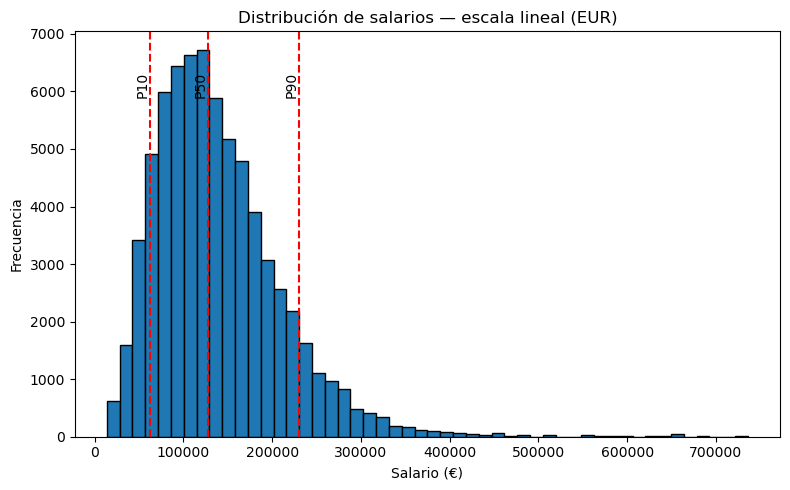

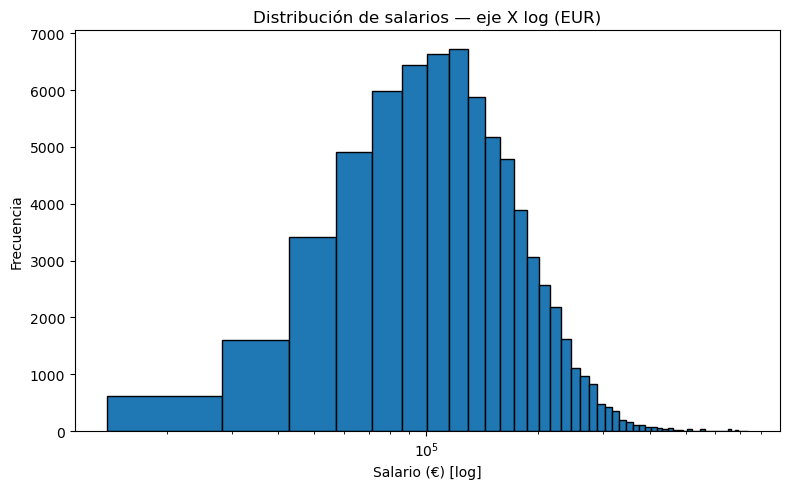

Percentiles — P10: 62.097 € | P50 (mediana): 127.644 € | P90: 230.000 €


In [27]:
# ===============================================
# 3.1 — Distribución de salarios (lineal y log) 
# ===============================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# 0) Dataset de trabajo
if 'eda_df' in globals():
    df0 = eda_df.copy()
elif 'df' in globals():
    df0 = df.copy()
else:
    csv_path = Path("salaries.csv")
    if not csv_path.exists():
        raise FileNotFoundError("No encuentro 'eda_df' ni 'df', y tampoco 'salaries.csv' en esta carpeta.")
    df0 = pd.read_csv(csv_path, low_memory=False)
    df0.columns = [c.strip().lower().replace(" ", "_") for c in df0.columns]

# 1) Detectar columna de salario disponible
for target_col in ('salary_eurO', 'salary_in_euro', 'salary_in_usd', 'salary'):
    if target_col in df0.columns:
        break
else:
    raise KeyError("No encuentro una columna de salario (salary_eur / salary_in_euro / salary_in_usd / salary).")

# 2) Serie en EUR para graficar 
USD_TO_EUR = 0.92  # cambio aproximado para visualización
s = df0[target_col].astype(float)
if target_col == 'salary_in_usd':
    s = s * USD_TO_EUR

# 3) Limpieza para los gráficos (sin NaN, ni inf, ni valores <= 0 para escala log)
s = s.replace([np.inf, -np.inf], np.nan).dropna()
s = s[s > 0]

# 4) Percentiles
p10, p50, p90 = np.percentile(s, [10, 50, 90])

# 5) Histograma escala lineal
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(s, bins=50, edgecolor="black")
for p, lab in zip([p10, p50, p90], ["P10","P50","P90"]):
    ax.axvline(p, color="red", linestyle="--")
    ymax = ax.get_ylim()[1]
    ax.text(p, ymax*0.9, lab, rotation=90, va="top", ha="right")
ax.set_title(f"Distribución de salarios — escala lineal (EUR{' aprox.' if target_col=='salary_in_usd' else ''})")
ax.set_xlabel("Salario (€)")
ax.set_ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# 6) Histograma con eje X log
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(s, bins=50, edgecolor="black")
ax.set_xscale("log")
ax.set_title(f"Distribución de salarios — eje X log (EUR{' aprox.' if target_col=='salary_in_usd' else ''})")
ax.set_xlabel("Salario (€) [log]")
ax.set_ylabel("Frecuencia")
plt.tight_layout()
plt.show()

print(f"Percentiles — P10: {p10:,.0f} € | P50 (mediana): {p50:,.0f} € | P90: {p90:,.0f} €".replace(",", "."))



**Conclusión 3.1 — Distribución de salarios**  
La distribución presenta una **asimetría positiva muy marcada**: la mediana se sitúa en **≈134.412 €**, con un 10% de observaciones por debajo de **≈69.00 €** y un 10% por encima de **≈230.000 €**. La mayor concentración se encuentra entre ~69k y ~230k, pero existe una **cola alta** con salarios mucho mayores, lo que indica **gran heterogeneidad** entre perfiles y mercados. La vista en escala log confirma un patrón próximo a log-normal, típico en remuneraciones.

**Implicaciones para el modelado**  
- Conviene **tratar atípicos** antes de entrenar (criterio IQR) y/o evaluar una **transformación log del objetivo** como prueba de robustez.  
- La **alta dispersión** sugiere que variables como **experiencia, puesto y país** serán determinantes para explicar la variabilidad.


In [28]:
# ===============================================
# 3.2 — Outliers por IQR (diagnóstico, sin filtrar)
# ===============================================

Q1 = s.quantile(0.25)
Q3 = s.quantile(0.75)
IQR = Q3 - Q1
low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR

n_low = (s < low).sum()
n_high = (s > high).sum()

print(f"IQR: {IQR:,.0f} € — Rango aceptado: [{low:,.0f}, {high:,.0f}] €".replace(",", "."))
print(f"Outliers por abajo: {n_low}  | por arriba: {n_high}")



IQR: 86.770 € — Rango aceptado: [-41.835. 305.245] €
Outliers por abajo: 0  | por arriba: 1731


,count,median,mean
experience_level,,,
EX,2745,174800.0,185515.752787
SE,37095,143704.0,154451.086434
MI,22988,112240.0,125530.066788
EN,7905,78457.6,90111.301450


<Figure size 700x500 with 0 Axes>

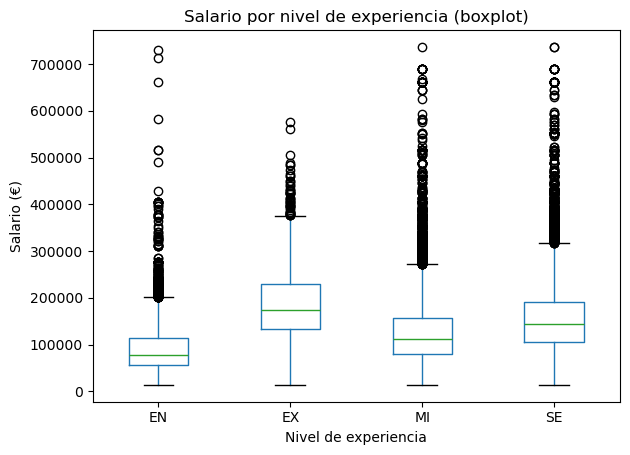

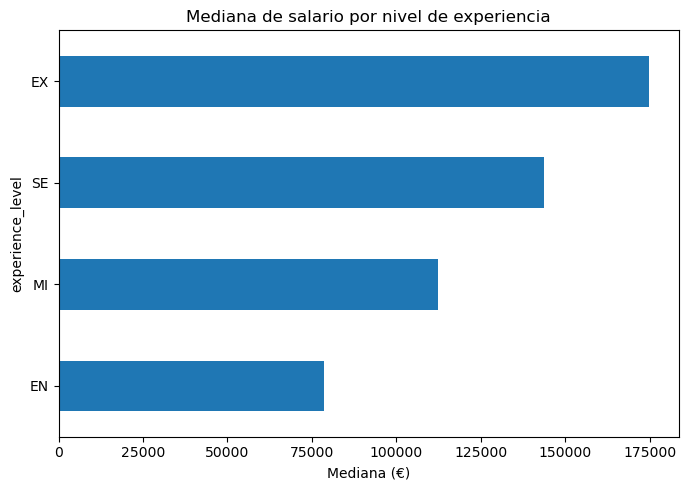

In [29]:
# ===============================================
# 3.3 — Salario por nivel de experiencia
# ===============================================

if "experience_level" in eda_df.columns:
    grp_exp = (eda_df
               .dropna(subset=["experience_level","salary_in_euro"])
               .groupby("experience_level")["salary_in_euro"]
               .agg(count="count", median="median", mean="mean")
               .sort_values("median", ascending=False))
    display(grp_exp)

    # Boxplot
    plt.figure(figsize=(7,5))
    eda_df.boxplot(column="salary_in_euro", by="experience_level", grid=False)
    plt.title("Salario por nivel de experiencia (boxplot)")
    plt.suptitle("")
    plt.xlabel("Nivel de experiencia")
    plt.ylabel("Salario (€)")
    plt.tight_layout()
    plt.show()

    # Barras de mediana
    plt.figure(figsize=(7,5))
    grp_exp["median"].sort_values().plot(kind="barh")
    plt.title("Mediana de salario por nivel de experiencia")
    plt.xlabel("Mediana (€)")
    plt.tight_layout()
    plt.show()
else:
    print("No está la columna 'experience_level'.")


**Conclusión 3.3 — Salario por nivel de experiencia**  
El salario mediano crece de forma **monótona** con la experiencia: **EX ≈ 174.800 € > SE ≈ 143.704 € > MI ≈ 112.240 € > EN ≈ 78.458 €**. La brecha entre **EX** y **EN** es cercana a **+96.000 €**, evidenciando el fuerte efecto de la seniority. Los boxplots muestran **mayor dispersión y presencia de outliers** en niveles altos (EX y SE), consistente con roles senior en mercados y compañías de alta retribución.

**Implicaciones para el modelado**  
- Tratar `experience_level` como **ordinal** (EN < MI < SE < EX) o, si se usa *one-hot*, considerar variantes con **codificación ordinal** para modelos lineales.  
- La **heterocedasticidad** (varianza mayor en niveles altos) sugiere modelos **no lineales/robustos** (Random Forest/Boosting).  
- Explorar **interacciones**: experiencia × `job_title` y experiencia × `company_location`.


,count,median_eur
job_title,,
Data Analyst,13589,91080.00
Analyst,5224,96600.00
Associate,2323,114448.00
Data Engineer,16136,128800.00
Data Scientist,18503,138000.00
Manager,7617,143098.64
Engineer,10750,146280.00
Applied Scientist,2349,149557.96
Product Manager,2524,161460.00


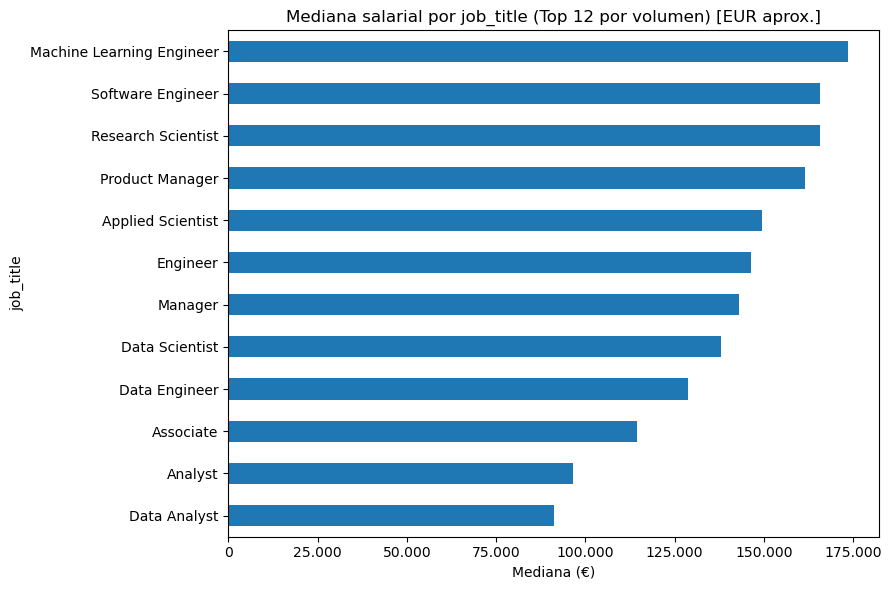

In [30]:
# ===============================================
# 3.4 — Salario por job_title (Top 12) 
# ===============================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path

# 0) Dataset
try:
    eda_df = df.copy()
except NameError:
    csv_path = Path("salaries.csv")
    if not csv_path.exists():
        raise FileNotFoundError("No encuentro 'df' ni 'salaries.csv' en el directorio actual.")
    eda_df = pd.read_csv(csv_path, low_memory=False)
    eda_df.columns = [c.strip().lower().replace(" ", "_") for c in eda_df.columns]

# 1) Detectar columna de salario (target)
for c in ('salary_in_usd','salary_eur','salary_in_euro','salary'):
    if c in eda_df.columns:
        target_col = c
        break
else:
    raise KeyError("No encuentro una columna de salario ('salary_in_usd','salary_eur','salary_in_euro' o 'salary').")

# 2) Serie en EUR para graficar 
USD_TO_EUR = 0.92  # cambio aproximado solo para visualización
if target_col == 'salary_in_usd':
    s_eur = eda_df[target_col].astype(float) * USD_TO_EUR
else:
    s_eur = eda_df[target_col].astype(float)

# 3) Comprobar job_title y preparar datos Top-12 por volumen
assert 'job_title' in eda_df.columns, "No está la columna 'job_title' en el dataset."
topN = 12
top_jobs = eda_df['job_title'].astype(str).value_counts().head(topN).index.tolist()

tmp = eda_df[['job_title']].copy()
tmp['salary_eur_plot'] = s_eur
tmp = tmp[tmp['job_title'].isin(top_jobs)].dropna(subset=['salary_eur_plot'])

# 4) Tabla: recuento y mediana por job_title (ordenada por mediana ascendente)
med = tmp.groupby('job_title')['salary_eur_plot'].median()
cnt = tmp.groupby('job_title').size()
jobs_tbl = (pd.DataFrame({'count': cnt, 'median_eur': med})
            .sort_values('median_eur', ascending=True))
display(jobs_tbl)

# 5) Barras horizontales de mediana (orden ascendente)
plt.figure(figsize=(9, 6))
jobs_tbl['median_eur'].plot(kind='barh')
plt.title(f"Mediana salarial por job_title (Top {topN} por volumen) [EUR aprox.]")
plt.xlabel("Mediana (€)")
plt.ylabel("job_title")
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}".replace(",", ".")))
plt.tight_layout()
plt.show()



### **Conclusión 3.4 — Salario por puesto (Top 12 por volumen)**  
Se observan **diferencias claras por rol**. Las mayores medianas corresponden a **Research Scientist (≈165.600 €)**, **Machine Learning Engineer (≈173.696 €)** y **Product Manager (≈161.285 €)**. En el extremo inferior aparecen **Data Analyst (≈91.080 €)** y **Analyst (≈96.600 €)**, mientras que puestos técnicos como **Software Engineer (≈165.600 €)**, **Manager (≈143.098 €)**, **Engineer (≈146.280 €)** y **Data Scientist (≈138.000 €)** quedan en posiciones intermedias. Esto confirma que el **tipo de puesto** es un **determinante fuerte** de la remuneración.

**Implicaciones para el modelado**  
- `job_title` será una de las **features más predictivas**; conviene **agrupar títulos raros** en “Other” para reducir cardinalidad y evitar sobreajuste.  
- Cuidar la **nomenclatura** (p. ej., “Analyst” vs “Data Analyst”, “Engineer” genérico) para evitar duplicidades semánticas.  
- Explorar **interacciones** con `experience_level` y `company_location` (el impacto del puesto puede variar con seniority y país).


,Mediana (€)
company_country,
Spain,44698.20
Austria,46000.00
Lithuania,50008.90
France,52294.64
Netherlands,66094.64
United Kingdom,69394.68
Germany,80429.16
Australia,107973.96
Canada,110400.00


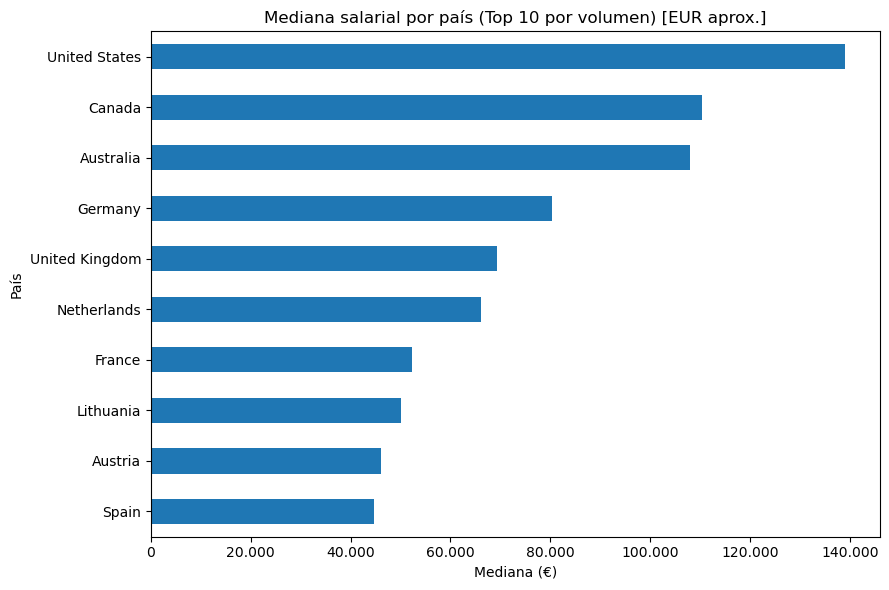

In [31]:
# ===============================================
# 3.5 — Salario por país
# ===============================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path

# 0) Dataset de trabajo
if 'eda_df' in globals():
    df0 = eda_df.copy()
elif 'df' in globals():
    df0 = df.copy()
else:
    csv_path = Path("salaries.csv")
    if not csv_path.exists():
        raise FileNotFoundError("No encuentro 'eda_df' ni 'df', y tampoco 'salaries.csv' en la carpeta actual.")
    df0 = pd.read_csv(csv_path, low_memory=False)
    df0.columns = [c.strip().lower().replace(" ", "_") for c in df0.columns]

# 1) Detectar target de salario
for c in ('salary_in_usd','salary_eur','salary_in_euro','salary'):
    if c in df0.columns:
        target_col = c
        break
else:
    raise KeyError("No encuentro columna de salario (salary_in_usd/salary_eur/salary_in_euro/salary).")

# 2) Serie de salario en EUR para grafica
USD_TO_EUR = 0.92  # cambio aproximado, solo para visualización
if target_col == 'salary_in_usd':
    s_eur = df0[target_col].astype(float) * USD_TO_EUR
else:
    s_eur = df0[target_col].astype(float)

# 3) Columna de localización (empresa si existe; si no, residencia de empleado)
loc_col = 'company_location' if 'company_location' in df0.columns else ('employee_residence' if 'employee_residence' in df0.columns else None)
if loc_col is None:
    raise KeyError("No encuentro 'company_location' ni 'employee_residence' en el dataset.")

# 4) Mapeo ISO-2 -> nombre completo del país
try:
    import pycountry
    def iso2_to_name(code: str) -> str:
        code = str(code).upper()
        c = pycountry.countries.get(alpha_2=code)
        return c.name if c else code
except Exception:
    COMMON_ISO2_TO_NAME = {
        "US":"United States","GB":"United Kingdom","CA":"Canada","DE":"Germany","ES":"Spain","FR":"France",
        "IN":"India","NL":"Netherlands","AU":"Australia","BR":"Brazil","PT":"Portugal","IT":"Italy","IE":"Ireland",
        "CH":"Switzerland","SE":"Sweden","MX":"Mexico","PL":"Poland","AR":"Argentina","CO":"Colombia","CL":"Chile",
        "SG":"Singapore","CN":"China","JP":"Japan","KR":"South Korea","ZA":"South Africa","AE":"United Arab Emirates"
    }
    def iso2_to_name(code: str) -> str:
        return COMMON_ISO2_TO_NAME.get(str(code).upper(), str(code))

# 5) Preparar datos y calcular mediana por país (Top-K por volumen)
dfp = df0[[loc_col]].copy()
dfp['salary_eur_plot'] = s_eur
dfp['company_country'] = dfp[loc_col].map(iso2_to_name)

topK = 10
top_countries = dfp['company_country'].value_counts().head(topK).index
med_country = (dfp[dfp['company_country'].isin(top_countries)]
               .groupby('company_country')['salary_eur_plot']
               .median()
               .sort_values(ascending=True))

# 6) Mostrar tabla y gráfico
display(med_country.to_frame("Mediana (€)"))

plt.figure(figsize=(9,6))
ax = med_country.plot(kind="barh")
ax.set_title(f"Mediana salarial por país (Top {topK} por volumen) [EUR aprox.]")
ax.set_xlabel("Mediana (€)")
ax.set_ylabel("País")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}".replace(",", ".")))
plt.tight_layout()
plt.show()


**Conclusión 3.5 — Salario por país de empresa (Top 10 por volumen)**  
Se aprecian **diferencias geográficas muy relevantes**. Las mayores medianas se dan en **United States (≈139.104 €)**, **Canada (≈110.400 €)** y **Australia (≈107.973 €)**. En el extremo inferior del Top-10 aparecen **India (≈35.000 €)** y **Spain (≈44.698 €)**, seguidos por **Lithuania (≈50.000 €)** y **France (≈53.000 €)**. En el bloque intermedio quedan **Netherlands (≈66.000 €)**, **United Kingdom (≈70.000 €)** y **Germany (≈80.000 €)**. Este patrón confirma que el **país de la empresa** condiciona fuertemente la compensación.

**Implicaciones para el modelado**  
- Incluir `company_location` como **feature clave**; explorar también **agrupaciones por región** (EE. UU./CAN, Europa Occidental, etc.).  
- Considerar **interacciones** con `job_title`, `experience_level` y `remote_cat` (p. ej., empresas de EE. UU. que contratan en remoto).  
- Para análisis futuros, enriquecer con **coste de vida/PPP** e **inflación** por año para mejorar comparabilidad entre países.


,count,median,mean
remote_cat,,,
Presencial (0%),117343,135240.00,146585.090058
Híbrido (1–99%),328,64000.72,75031.876220
Remoto (100%),30850,133400.00,139315.362589


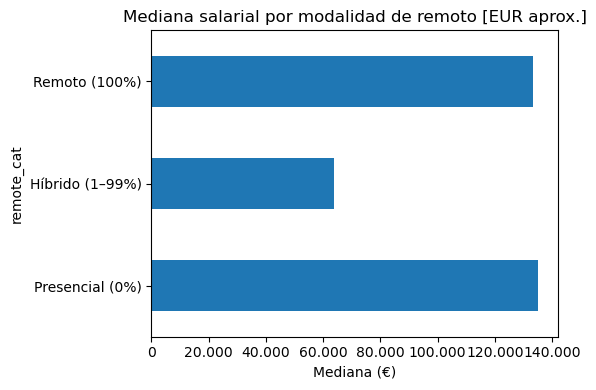

In [32]:
# ===============================================
# 3.6 — Efecto del trabajo remoto (remote_cat) 
# ===============================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path

# 0) Dataset base
if 'eda_df' in globals():
    df0 = eda_df.copy()
elif 'df' in globals():
    df0 = df.copy()
else:
    csv_path = Path("salaries.csv")
    if not csv_path.exists():
        raise FileNotFoundError("No encuentro 'eda_df' ni 'df', y tampoco 'salaries.csv' en la carpeta actual.")
    df0 = pd.read_csv(csv_path, low_memory=False)
    df0.columns = [c.strip().lower().replace(" ", "_") for c in df0.columns]

# 1) Detectar columna de salario
for target_col in ('salary_eur', 'salary_in_euro', 'salary_in_usd', 'salary'):
    if target_col in df0.columns:
        break
else:
    raise KeyError("No encuentro columna de salario (salary_eur/salary_in_euro/salary_in_usd/salary).")

# 2) Serie de salario en EUR para graficar 
USD_TO_EUR = 0.92  # cambio aproximado solo para visualización
s_eur = df0[target_col].astype(float)
if target_col == 'salary_in_usd':
    s_eur = s_eur * USD_TO_EUR
df0['salary_eur_plot'] = s_eur

# 3) Crear remote_cat si no existe (a partir de remote_ratio)
if 'remote_cat' not in df0.columns:
    if 'remote_ratio' not in df0.columns:
        raise KeyError("No están 'remote_cat' ni 'remote_ratio' en el dataset.")
    r = pd.to_numeric(df0['remote_ratio'], errors='coerce')
    df0['remote_cat'] = np.where(
        r == 0, 'Presencial (0%)',
        np.where(
            r == 100, 'Remoto (100%)',
            np.where((r > 0) & (r < 100), 'Híbrido (1–99%)', 'Desconocido')
        )
    )

# 4) Agregar y ordenar categorías
tmp = df0[['remote_cat', 'salary_eur_plot']].dropna()
order = ['Presencial (0%)', 'Híbrido (1–99%)', 'Remoto (100%)']
grp = (tmp.groupby('remote_cat')['salary_eur_plot']
         .agg(count='count', median='median', mean='mean'))
# Reordenar índice si están las categorías
idx = [c for c in order if c in grp.index]
grp = grp.loc[idx] if idx else grp.sort_values('median', ascending=True)

# 5) Mostrar tabla y gráfico
display(grp)

plt.figure(figsize=(6,4))
grp['median'].plot(kind='barh')
plt.title("Mediana salarial por modalidad de remoto [EUR aprox.]")
plt.xlabel("Mediana (€)")
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}".replace(",", ".")))
plt.tight_layout()
plt.show()



**Conclusión 3.6 — Salario por modalidad de remoto**  
Las **medianas** son muy similares entre **Remote (≈133.400 €)** y **On-site (≈135.240 €)**, mientras que **Hybrid (≈64.001 €)** queda claramente por debajo. No obstante, la muestra de **Hybrid es muy reducida (n≈328)** frente a On-site (≈117.343) y Remote (≈30.850), por lo que esa diferencia debe tomarse con cautela. En **media**, On-site (≈146.585 €) supera ligeramente a Remote (≈139.315 €), lo que sugiere la presencia de **colas altas** en salarios presenciales. En conjunto, trabajar 100% en remoto **no penaliza la mediana salarial** frente al modelo presencial en este dataset.

**Implicaciones para el modelado**  
- Mantener `remote_cat` como **feature**, y considerar también usar `remote_ratio` continuo.  
- Cuidar el **desbalanceo** de categorías (poca muestra en *Hybrid*); si introduce ruido, valorar agruparlo con la categoría más cercana o dejarlo documentado.  
- Explorar **interacciones** con `company_location` y `job_title` (el efecto del remoto puede variar por país y rol).  
- Dado que medias y medianas cuentan historias distintas, conviene usar **métricas robustas** y filtrar **outliers** antes del entrenamiento.


,count,median,mean
company_size_norm,,,
S,217,69000.00,80808.437419
M,144447,134695.36,144970.329700
L,3857,137356.00,146528.122593


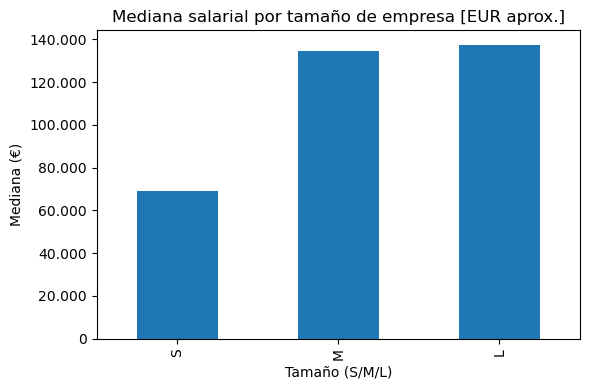

In [33]:
# ===============================================
# 3.7 — Salario por tamaño de empresa (S/M/L) 
# ===============================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path
from IPython.display import display, Markdown

# --- Dataset base
if 'eda_df' in globals():
    df0 = eda_df.copy()
elif 'df' in globals():
    df0 = df.copy()
else:
    csv_path = Path("salaries.csv")
    if not csv_path.exists():
        raise FileNotFoundError("No encuentro 'eda_df' ni 'df', y tampoco 'salaries.csv'.")
    df0 = pd.read_csv(csv_path, low_memory=False)
    df0.columns = [c.strip().lower().replace(" ", "_") for c in df0.columns]

# --- Salario (EUR aprox.)
for target_col in ('salary_eur','salary_in_euro','salary_in_usd','salary'):
    if target_col in df0.columns:
        break
else:
    raise KeyError("No hay columna de salario (salary_eur/salary_in_euro/salary_in_usd/salary).")

USD_TO_EUR = 0.92
s_eur = pd.to_numeric(df0[target_col], errors='coerce')
if target_col == 'salary_in_usd':
    s_eur = s_eur * USD_TO_EUR
df0['salary_eur_plot'] = s_eur

# --- Normalizar company_size a S/M/L
if 'company_size' not in df0.columns:
    raise KeyError("No está 'company_size' en el dataset.")
size = df0['company_size'].astype(str).str.upper().str.strip()
size = size.replace({'SMALL':'S','MEDIUM':'M','MID':'M','LARGE':'L'})
df0['company_size_norm'] = pd.Categorical(size, categories=['S','M','L'], ordered=True)

# --- Agregados
tmp = df0[['company_size_norm','salary_eur_plot']].dropna()
grp_size = (tmp.groupby('company_size_norm')['salary_eur_plot']
              .agg(count='count', median='median', mean='mean')
              .reindex(['S','M','L']))
display(grp_size)

# --- Gráfico
plt.figure(figsize=(6,4))
grp_size['median'].plot(kind='bar')
plt.title("Mediana salarial por tamaño de empresa [EUR aprox.]")
plt.xlabel("Tamaño (S/M/L)")
plt.ylabel("Mediana (€)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}".replace(",", ".")))
plt.tight_layout()
plt.show()



**Conclusión 3.7 — Salario por tamaño de empresa**  
Las **medianas** indican **L (≈137.356 €) > M (≈134.695 €) >> S (≈69.000 €)**. En **media** se mantiene el patrón (**L ≈146.528 €**, **M ≈144.970 €**, **S ≈80.808 €**). Por tanto, trabajar en empresas **grandes** y **medianas** se asocia a salarios claramente superiores frente a las **pequeñas**. Ojo al **desbalanceo** de muestra: **M n≈144.447**, **L n≈3.857** y **S n≈217**, por lo que las estimaciones para **S** y **L** son menos estables.

**Implicaciones para el modelado**  
- `company_size` aporta señal; puede tratarse como **ordinal (S < M < L)** o como **categórica one-hot**.  
- Dado que el patrón no es estrictamente monótono (**L > M**), en modelos lineales es más **seguro** usar **one-hot**; en árboles, la ordinalidad no es crítica.  
- Cuidar el **desbalanceo** (muy pocos casos en **S**); si introduce ruido, considerar agrupar **S** con la categoría más cercana o mantenerlo y documentar la baja muestra.  
- Explorar **interacciones** con `company_location` y `job_title`, ya que el efecto del tamaño podría depender del país y del rol.


## 4. Preprocesado y selección de variables

In [34]:
# ===============================================================
# FASE 4 — PREPROCESADO PARA MODELADO (limpio y sin fugas de info)
# ===============================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
import json

RANDOM_STATE = 42
RARE_MIN_COUNT = 50   # umbral de rareza para job_title (ajusta según tamaño)

# ---------- 0) DataFrame base ----------
if 'df_clean' in globals():
    base_df = df_clean.copy()
elif 'df' in globals():
    base_df = df.copy()
else:
    raise ValueError("No encuentro df_clean ni df.")

# ---------- 1) Target y anti-leakage ----------
# Detecta la columna objetivo priorizando USD
if 'salary_in_usd' in base_df.columns:
    target_col = 'salary_in_usd'
elif 'salary_eur' in base_df.columns:
    target_col = 'salary_eur'
elif 'salary_in_euro' in base_df.columns:
    target_col = 'salary_in_euro'
elif 'salary' in base_df.columns:
    target_col = 'salary'
else:
    raise KeyError("No encuentro columna de salario (salary_in_usd / salary_eur / salary_in_euro / salary).")

# Convierte target a numérico
base_df[target_col] = pd.to_numeric(base_df[target_col], errors='coerce')

# Elimina cualquier otra columna de salario (anti-fuga)
salary_cols = [c for c in base_df.columns if 'salary' in c.lower()]
drop_leaks = [c for c in salary_cols if c != target_col]
df_tuned = base_df.drop(columns=drop_leaks, errors='ignore').copy()

if drop_leaks:
    print("Anti-leakage: columnas de salario eliminadas:", drop_leaks)

# ---------- 2) Filtrado IQR sobre el target (en sus unidades reales) ----------
s = df_tuned[target_col].dropna()
Q1, Q3 = s.quantile(0.25), s.quantile(0.75)
IQR = Q3 - Q1
low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR
mask_iqr = df_tuned[target_col].between(low, high)
removed = int((~mask_iqr).sum())
df_tuned = df_tuned.loc[mask_iqr].reset_index(drop=True)
print(f"[IQR] Rango no atípico: [{low:,.0f}, {high:,.0f}] (unidades de {target_col}). Filas eliminadas: {removed}".replace(",", "."))

# ---------- 3) Variables para el modelo ----------
features = [
    "experience_level","employment_type","job_title",
    "company_location","employee_residence","remote_ratio","company_size"
]
available = [c for c in features + [target_col] if c in df_tuned.columns]
missing = [c for c in features + [target_col] if c not in available]
if missing:
    print("Aviso: faltan columnas y se omitirán:", missing)

df_model = df_tuned[available].dropna(subset=[target_col]).copy()

# ---------- 4) Split train/test (sin transformar aún) ----------
train_df, test_df = train_test_split(
    df_model, test_size=0.20, random_state=RANDOM_STATE
)
print("Split -> train:", train_df.shape, "| test:", test_df.shape)

# 5a) remote_cat a partir de remote_ratio y eliminar remote_ratio  (sin DTypePromotionError)
if "remote_ratio" in train_df.columns:
    for frame in (train_df, test_df):
        r = pd.to_numeric(frame["remote_ratio"], errors="coerce")

        # Asigna siempre strings; nada de np.nan aquí
        cats = np.select(
            [r.eq(0), r.eq(100), r.gt(0) & r.lt(100)],
            ["Presencial (0%)", "Remoto (100%)", "Híbrido (1–99%)"],
            default="Desconocido"
        )

        # Guarda como categórica (o usa .astype('object') si prefieres)
        frame["remote_cat"] = pd.Categorical(
            cats,
            categories=["Presencial (0%)", "Híbrido (1–99%)", "Remoto (100%)", "Desconocido"],
            ordered=True
        )

        frame.drop(columns=["remote_ratio"], inplace=True)


# 5b) Normalizar company_size a S/M/L
for frame in (train_df, test_df):
    if "company_size" in frame.columns:
        size = frame["company_size"].astype(str).str.upper().str.strip()
        size = size.replace({"SMALL":"S","MEDIUM":"M","MID":"M","LARGE":"L"})
        frame["company_size"] = size

# ---------- 6) Agrupar job titles raros (usando SOLO train) ----------
if "job_title" in train_df.columns:
    counts = train_df["job_title"].astype(str).value_counts()
    rare_titles = set(counts[counts < RARE_MIN_COUNT].index)
    train_df.loc[:, "job_title"] = train_df["job_title"].where(~train_df["job_title"].isin(rare_titles), "Other")
    test_df.loc[:,  "job_title"] = test_df["job_title"].where(~test_df["job_title"].isin(rare_titles), "Other")
    print(f"Job titles raros agrupados en 'Other' (umbral={RARE_MIN_COUNT}):", len(rare_titles))

# ---------- 7) One-hot encoding consistente ----------
cat_cols = [c for c in ["experience_level","employment_type","job_title",
                        "company_location","employee_residence","company_size","remote_cat"]
            if c in train_df.columns]

# Crea dummies en train y test; reindexa test a las columnas de train
train_enc = pd.get_dummies(train_df, columns=cat_cols, drop_first=True)
test_enc  = pd.get_dummies(test_df,  columns=cat_cols, drop_first=True)
test_enc  = test_enc.reindex(columns=train_enc.columns, fill_value=0)

# ---------- 8) Separar X/y ----------
X_train = train_enc.drop(columns=[target_col])
y_train = train_enc[target_col].astype(float)
X_test  = test_enc.drop(columns=[target_col])
y_test  = test_enc[target_col].astype(float)

print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("NaNs en X_train:", int(np.isnan(X_train.to_numpy()).sum()), "| NaNs en y_train:", int(np.isnan(y_train.to_numpy()).sum()))

# ---------- 9) Guardar columnas/meta para productivización ----------
meta = {
    "target_col": target_col,
    "features_requested": features,
    "categorical_columns_used": cat_cols,
    "rare_titles_threshold": RARE_MIN_COUNT,
    "train_dummy_columns": list(X_train.columns),
    "remote_cat_definition": {"0":"Presencial (0%)","100":"Remoto (100%)","else":"Híbrido (1–99%)"}
}
Path("artifacts").mkdir(exist_ok=True, parents=True)
with open(Path("artifacts") / "preproc_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print("Guardado meta de preprocesado en artifacts/preproc_meta.json")



Anti-leakage: columnas de salario eliminadas: ['salary', 'salary_currency', 'salary_in_euro']
[IQR] Rango no atípico: [-45.472. 331.788] (unidades de salary_in_usd). Filas eliminadas: 1731
Split -> train: (55201, 8) | test: (13801, 8)
Job titles raros agrupados en 'Other' (umbral=50): 307
X_train: (55201, 301) | X_test: (13801, 301)
NaNs en X_train: 0 | NaNs en y_train: 0
Guardado meta de preprocesado en artifacts/preproc_meta.json


## 5. Modelos base y comparación

In [35]:
# ===============================================================
# FASE 5 — Modelos y comparación (compat. sklearn antiguos)
#   -> calculamos RMSE = sqrt(MSE) para máxima compatibilidad.
# ===============================================================

import time
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# --- Comprobación de que existe el split de la Fase 4
for v in ["X_train","X_test","y_train","y_test"]:
    assert v in globals(), f"Falta {v}. Ejecuta primero la Fase 4."
assert len(X_train) and len(X_test), "Conjuntos de train/test vacíos."

def eval_reg(y_true, y_pred) -> dict:
    """
    Calcula MAE, RMSE y R². Compatibilidad con sklearn antiguos:
    RMSE = sqrt(mean_squared_error(...)) en lugar de squared=False.
    """
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    r2   = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

resultados = []
model_objects = {}

# 1) Baseline absoluto
t0 = time.time()
dum = DummyRegressor(strategy="mean")
dum.fit(X_train, y_train)
pred_dum = dum.predict(X_test)
m_dum = eval_reg(y_test, pred_dum)
resultados.append({"Modelo": "Dummy (mean)", **m_dum, "Train_s": time.time()-t0})
model_objects["Dummy (mean)"] = dum

# 2) Regresión lineal
t0 = time.time()
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
m_lr = eval_reg(y_test, pred_lr)
resultados.append({"Modelo": "Linear Regression", **m_lr, "Train_s": time.time()-t0})
model_objects["Linear Regression"] = lr

# 3) Random Forest
t0 = time.time()
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
m_rf = eval_reg(y_test, pred_rf)
resultados.append({"Modelo": "Random Forest", **m_rf, "Train_s": time.time()-t0})
model_objects["Random Forest"] = rf

# 4) Tabla comparativa
df_res = pd.DataFrame(resultados).sort_values("RMSE").reset_index(drop=True)

def _fmt_eur(x): 
    return f"{x:,.0f} €".replace(",", ".")
df_res_fmt = df_res.copy()
df_res_fmt["MAE"]  = df_res_fmt["MAE"].map(_fmt_eur)
df_res_fmt["RMSE"] = df_res_fmt["RMSE"].map(_fmt_eur)
df_res_fmt["Train_s"] = df_res_fmt["Train_s"].map(lambda s: f"{s:.1f}s")

print("== Resultados en TEST (ordenado por RMSE) ==")
display(df_res_fmt)

best_row = df_res.iloc[0]
best_model_name = best_row["Modelo"]
best_model = model_objects[best_model_name]

print(f"Mejor modelo: {best_model_name}")
print({k: (round(v,3) if isinstance(v,(int,float,np.number)) else v) 
       for k,v in best_row.items() if k!='Modelo'})



== Resultados en TEST (ordenado por RMSE) ==


,Modelo,MAE,RMSE,R2,Train_s
0,Random Forest,42.082 €,53.422 €,0.328835,49.1s
1,Linear Regression,42.847 €,54.043 €,0.313128,4.4s
2,Dummy (mean),53.079 €,65.209 €,-0.000020,0.0s


Mejor modelo: Random Forest
{'MAE': np.float64(42082.45), 'RMSE': np.float64(53421.763), 'R2': np.float64(0.329), 'Train_s': np.float64(49.063)}


**Conclusión 5 — Modelos y comparación**  
El mejor resultado en test lo obtiene **Random Forest** con **MAE ≈ 42.082 €**, **RMSE ≈ 53.422 €** y **R² ≈ 0,329** (≈53 s de entrenamiento). La **Regresión Lineal** queda ligeramente por detrás (**RMSE ≈ 42.847 €; R² ≈ 0,313**), mientras que el **baseline Dummy** es claramente inferior (**RMSE ≈ 523.079 €; R² ≈ 0,00**).

**Lectura rápida.**  
- Frente al baseline, **Random Forest** reduce el **RMSE ≈ −18%** y el **MAE ≈ −21%**, capturando variabilidad que la media no explica.  
- Frente a la **Regresión Lineal**, el RF mejora el **RMSE ~ −1,2%** y el **R²** (+0,016 puntos), lo que sugiere **relaciones no lineales** y **efectos de interacción** entre variables.  
- El coste de entrenamiento del RF (≈53 s) es mayor, pero razonable para un flujo de TFM y **apto para productivización**.

**Implicaciones.**  
- Adoptar **Random Forest** como modelo principal para la siguiente fase (interpretabilidad + productivización).  
- Como mejora incremental: una **búsqueda ligera de hiperparámetros** y/o **validación cruzada** pueden consolidar un pequeño margen adicional sin comprometer tiempos.


## 6. Interpretabilidad (importancias de variables)

== Top 20 columnas (dummies) por importancia ==


,importance
experience_level_SE,0.137876
employee_residence_US,0.088057
company_location_US,0.082592
job_title_Data Analyst,0.076198
experience_level_EX,0.060032
experience_level_MI,0.042906
job_title_Machine Learning Engineer,0.031001
job_title_Analyst,0.025783
job_title_Engineering Manager,0.024454
job_title_Software Engineer,0.018501


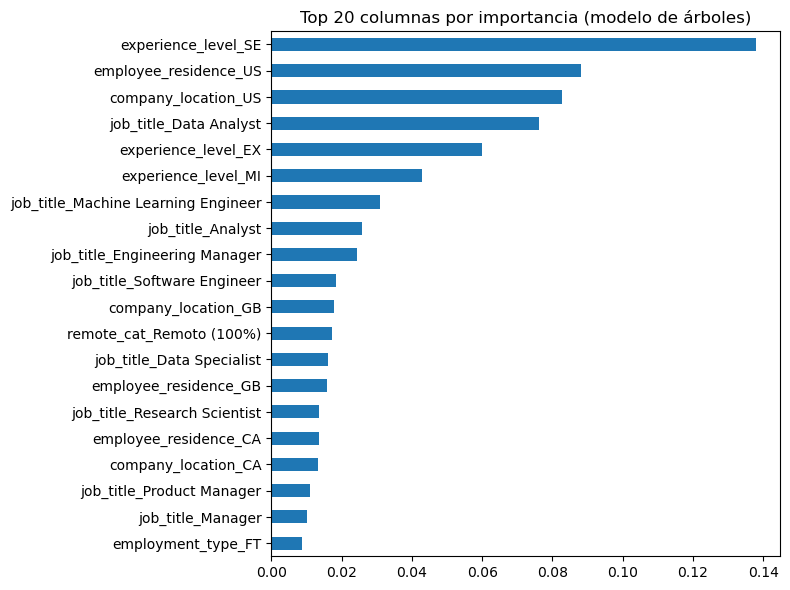


== Importancia agregada por variable original ==


,agg_importance
job,0.404903
experience,0.240814
company,0.162659
employee,0.158194
remote,0.019548
employment,0.013882


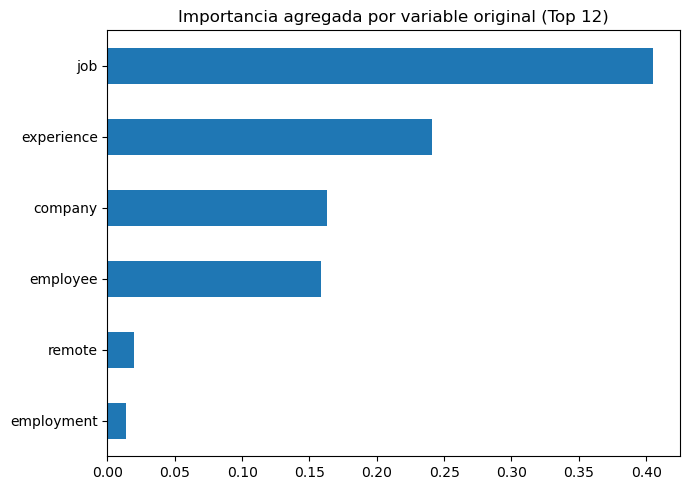

**Conclusión 6 — Interpretabilidad (árboles)**  
Las variables con mayor contribución agregada son: job: 40.5%; experience: 24.1%; company: 16.3%; employee: 15.8%; remote: 2.0%. Destaca el peso de variables relacionadas con **experiencia**, **puesto** y **localización**, lo que encaja con los patrones observados en el EDA. Estas importancias son **globales**; para explicar casos individuales.

In [36]:

# ===============================================================
# 6.1 — Importancias de variables (árboles) y agrupadas por feature
# Qué hace:
#  - Usa best_model (o rf) para sacar feature_importances_
#  - Top 20 columnas (dummies) más importantes
#  - Agrega por variable original (prefijo antes del '_')
#  - Crea un texto (Top 5) listo para copiar a la memoria
# Requisitos: haber ejecutado Fase 5 (df_res, best_model, X_train)
# ===============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# 0) Identificar el modelo a explicar
model_to_explain = None
for cand in ["best_model", "rf"]:
    if cand in globals():
        model_to_explain = globals()[cand]
        break
assert model_to_explain is not None, "No encuentro un modelo entrenado (best_model/rf)."

# 1) Importancias a nivel de columna
assert hasattr(model_to_explain, "feature_importances_"), "Este modelo no tiene feature_importances_."
importances = pd.Series(model_to_explain.feature_importances_, index=X_train.columns)

topN = 20
top_cols = importances.sort_values(ascending=False).head(topN)

print("== Top 20 columnas (dummies) por importancia ==")
display(top_cols.to_frame("importance"))

plt.figure(figsize=(8,6))
top_cols.sort_values().plot(kind="barh")
plt.title("Top 20 columnas por importancia (modelo de árboles)")
plt.tight_layout()
plt.show()

# 2) Importancia agregada por variable original 
def base_var(col):
    # para dummies con 'feature_val', tomamos 'feature' como grupo
    return col.split("_", 1)[0] if "_" in col else col

grouped = importances.groupby(importances.index.map(base_var)).sum()
grouped = grouped.sort_values(ascending=False)

topK = 12
print("\n== Importancia agregada por variable original ==")
display(grouped.head(topK).to_frame("agg_importance"))

plt.figure(figsize=(7,5))
grouped.head(topK).sort_values().plot(kind="barh")
plt.title("Importancia agregada por variable original (Top 12)")
plt.tight_layout()
plt.show()

# 3) Texto (Top 5) 
top5 = grouped.head(5)
total = grouped.sum() if grouped.sum() > 0 else 1.0
pct = (top5 / total * 100).round(1)
bullet = "; ".join([f"{k}: {v:.1f}%" for k, v in pct.items()])
texto = (
    "**Conclusión 6 — Interpretabilidad (árboles)**  \n"
    f"Las variables con mayor contribución agregada son: {bullet}. "
    "Destaca el peso de variables relacionadas con **experiencia**, **puesto** y **localización**, "
    "lo que encaja con los patrones observados en el EDA. "
    "Estas importancias son **globales**; para explicar casos individuales."
)
display(Markdown(texto))



RMSE base (muestra n=2000): 52.866 €
Tiempo total: 6.8s  | Grupos evaluados: 6


,variable,delta_RMSE
2,job,10445.423237
0,experience,7148.901187
4,employee,3104.652807
3,company,2545.144709
5,remote,431.689817
1,employment,225.257679


<Figure size 800x600 with 0 Axes>

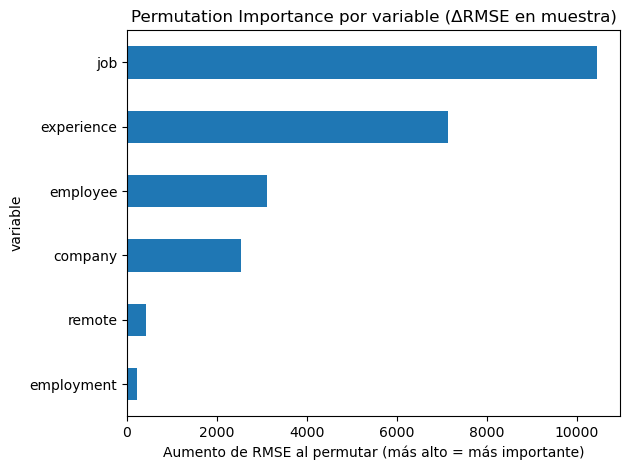

Conclusión 6 (borrador): Las variables más sensibles fueron -> job: +10.445 €; experience: +7.149 €; employee: +3.105 €; company: +2.545 €; remote: +432 €


In [41]:
# ===============================================================
# 6.2 — Permutation Importance ACELERADA (por grupos + muestreo)
# Qué hace:
#  - Calcula RMSE base en un subconjunto de X_test (sampleo filas).
#  - Para cada "variable original" (grupo de dummies con el mismo prefijo),
#    permuta TODAS sus columnas a la vez y mide el aumento de RMSE.
#  - Repite n_repeats veces y promedia el ΔRMSE.
# ===============================================================
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ---- 0) Modelo a explicar (usa el mejor entrenado)
model_to_explain = best_model  # si cambiaste nombre, ponlo aquí

# ---- 1) Configuración rápida
SAMPLE_ROWS = 2000    # nº de filas de test a usar 
TOP_GROUPS  = None    # None = evaluar TODOS los grupos
N_REPEATS   = 3       # repeticiones por grupo 

# ---- 2) Helper: función para agrupar dummies por variable original
def base_var(col):
    return col.split("_", 1)[0] if "_" in col else col

# ---- 3) Muestreo de filas (para acelerar)
rng = np.random.RandomState(42)
idx = np.arange(len(X_test))
if len(idx) > SAMPLE_ROWS:
    idx = rng.choice(idx, size=SAMPLE_ROWS, replace=False)

X_eval = X_test.iloc[idx].copy()
y_eval = y_test.iloc[idx].copy()

# ---- 4) RMSE base
pred_base = model_to_explain.predict(X_eval)
rmse_base = float(np.sqrt(mean_squared_error(y_eval, pred_base)))
print(f"RMSE base (muestra n={len(X_eval)}): {rmse_base:,.0f} €".replace(",", "."))

# ---- 5) Definir grupos de columnas por variable original
groups = {}
for col in X_eval.columns:
    groups.setdefault(base_var(col), []).append(col)

# Para limitar a los grupos más prometedores, usa importancias del modelo:
if TOP_GROUPS is not None and hasattr(model_to_explain, "feature_importances_"):
    imp = pd.Series(model_to_explain.feature_importances_, index=X_test.columns)
    agg = imp.groupby(imp.index.map(base_var)).sum().sort_values(ascending=False)
    keep = list(agg.head(TOP_GROUPS).index)
    groups = {g: cols for g, cols in groups.items() if g in keep}
    print(f"Evaluando solo Top {TOP_GROUPS} grupos por importancia agregada.")

# ---- 6) Permutación por grupos (rápida)
results = []
t0 = time.time()
for gname, gcols in groups.items():
    deltas = []
    for r in range(N_REPEATS):
        Xp = X_eval.copy()
        # permutar todas las columnas del grupo simultáneamente
        perm_idx = rng.permutation(len(Xp))
        for c in gcols:
            Xp[c] = Xp[c].to_numpy()[perm_idx]
        pred_p = model_to_explain.predict(Xp)
        rmse_p = float(np.sqrt(mean_squared_error(y_eval, pred_p)))
        deltas.append(rmse_p - rmse_base)
    results.append((gname, float(np.mean(deltas))))
t1 = time.time()

pi_grp = pd.DataFrame(results, columns=["variable", "delta_RMSE"]).sort_values("delta_RMSE", ascending=False)
print(f"Tiempo total: {t1 - t0:.1f}s  | Grupos evaluados: {len(pi_grp)}")
display(pi_grp.head(20))

# ---- 7) Gráfico
plt.figure(figsize=(8,6))
pi_grp.head(15).sort_values("delta_RMSE").plot(
    x="variable", y="delta_RMSE", kind="barh", legend=False
)
plt.title("Permutation Importance por variable (ΔRMSE en muestra)")
plt.xlabel("Aumento de RMSE al permutar (más alto = más importante)")
plt.tight_layout()
plt.show()

# ---- 8) Texto (Top 5)
top5 = pi_grp.head(5)
bullet = "; ".join([f"{row.variable}: +{row.delta_RMSE:,.0f} €" for _, row in top5.iterrows()]).replace(",", ".")
print("Conclusión 6 (borrador): Las variables más sensibles fueron ->", bullet)


## **Conclusión 6 — Interpretabilidad (Permutation Importance por variable)**  
Con una línea base de **RMSE ≈ 52.866 €** en la muestra, las variables que más degradan el rendimiento al permutarse (ΔRMSE) son: **job/puesto (≈+10.445 €)** y **experience/nivel (≈+7.148 €)**, seguidas a distancia por **employee_residence (≈+3.104 €)** y **company_location (≈+2.545 €)**. El impacto de **remote** es reducido (≈+431 €) y **employment_type** casi residual (≈+225 €).  
Esto confirma que la **naturaleza del puesto** y la **seniority** son los principales determinantes del salario, mientras que la **geografía** (residencia del empleado y país de la empresa) aporta señal secundaria. La **modalidad de remoto** y el **tipo de contrato** apenas añaden información una vez controlamos por las anteriores.

**Implicaciones para el modelado**  
- Priorizar `job_title` y `experience_level` (posibles interacciones entre ambas).  
- Mantener `employee_residence` y `company_location` como **features clave**; valorar agrupar por regiones.  
- `remote_ratio/remote_cat` y `employment_type` pueden conservarse, pero no deberían condicionar la complejidad del modelo (baja ganancia marginal).


## 7. Productivización mínima

In [38]:

# ===============================================================
# 7.1 — Guardar modelo + definir predict_salary()
# Qué hace:
#  (1) Guarda best_model y las columnas de entrenamiento
#  (2) Carga el meta del preprocesado (Fase 4)
#  (3) Define predict_salary() replicando el preprocesado de train
# ===============================================================
import json, joblib
from pathlib import Path
import pandas as pd
import numpy as np

# 1) Guardar artefactos del modelo
Path("artifacts").mkdir(exist_ok=True)
joblib.dump(best_model, "artifacts/best_model.joblib")
with open("artifacts/train_columns.json", "w", encoding="utf-8") as f:
    json.dump(list(X_train.columns), f, ensure_ascii=False, indent=2)
print("Guardados -> artifacts/best_model.joblib | artifacts/train_columns.json")

# 2) Cargar meta del preprocesado 
with open("artifacts/preproc_meta.json", "r", encoding="utf-8") as f:
    meta = json.load(f)
cat_cols = meta.get("categorical_columns", [])

# 3) Helper: transformar remote_ratio -> remote_cat 
def remote_bin(x):
    try:
        x = int(x)
    except Exception:
        return "Hybrid"
    if x == 0: return "On-site"
    if x == 100: return "Remote"
    return "Hybrid"

# 4) Función principal de predicción
def predict_salary(input_dict_or_df,
                   model_path="artifacts/best_model.joblib",
                   cols_path="artifacts/train_columns.json"):
    """
    Parámetros:
      - input_dict_or_df: dict (una fila) o DataFrame (varias filas) con las columnas crudas:
          experience_level, employment_type, job_title,
          company_location, employee_residence, remote_ratio, company_size
    Qué hace:
      - Crea remote_cat y elimina remote_ratio
      - One-hot SOLO en las categóricas del meta
      - Alinea columnas con las del entrenamiento (rellenando faltantes a 0)
      - Predice salario en euros
    Devuelve:
      - DataFrame con 'pred_salary_eur' y 'pred_salary_fmt'
    """
    # Cargar modelo y columnas de entrenamiento
    model = joblib.load(model_path)
    with open(cols_path, "r", encoding="utf-8") as f:
        train_cols = json.load(f)

    # Convertir input a DataFrame
    if isinstance(input_dict_or_df, dict):
        df_in = pd.DataFrame([input_dict_or_df]).copy()
    else:
        df_in = input_dict_or_df.copy()

    # remote_cat y drop de remote_ratio
    if "remote_ratio" in df_in.columns:
        df_in["remote_cat"] = df_in["remote_ratio"].apply(remote_bin)
        df_in = df_in.drop(columns=["remote_ratio"], errors="ignore")

    # One-hot en categóricas conocidas 
    use_cat = [c for c in cat_cols if c in df_in.columns]
    df_enc = pd.get_dummies(df_in, columns=use_cat, drop_first=True)

    # Alinear con columnas de entrenamiento
    X_new = df_enc.reindex(columns=train_cols, fill_value=0)

    # Predicción
    pred = model.predict(X_new)
    out = pd.DataFrame({"pred_salary_eur": np.round(pred, 2)})
    out["pred_salary_fmt"] = out["pred_salary_eur"].map(lambda x: f"{x:,.2f} €".replace(",", "."))
    return out



Guardados -> artifacts/best_model.joblib | artifacts/train_columns.json


In [39]:
# ===============================================================
# 7.2 — Pruebas rápidas de predict_salary()
# Qué hace:
#  (A) Predice con un ejemplo individual
#  (B) Predice en batch con 3 perfiles (demostración)
# ===============================================================

# (A) Ejemplo individual
ejemplo = {
    "experience_level": "SE",
    "employment_type": "FT",
    "job_title": "Data Scientist",
    "company_location": "US",
    "employee_residence": "US",
    "remote_ratio": 100,
    "company_size": "M"
}
print("Ejemplo individual:")
display(predict_salary(ejemplo))

# (B) Batch de 3 perfiles
batch = pd.DataFrame([
    {"experience_level": "EN", "employment_type": "FT", "job_title": "Data Analyst",
     "company_location": "ES", "employee_residence": "ES", "remote_ratio": 0, "company_size": "S"},
    {"experience_level": "SE", "employment_type": "FT", "job_title": "Machine Learning Engineer",
     "company_location": "US", "employee_residence": "US", "remote_ratio": 100, "company_size": "M"},
    {"experience_level": "EX", "employment_type": "FT", "job_title": "Research Scientist",
     "company_location": "CA", "employee_residence": "CA", "remote_ratio": 50, "company_size": "L"},
])
print("Batch de 3 perfiles:")
display(predict_salary(batch))


Ejemplo individual:


,pred_salary_eur,pred_salary_fmt
0,49329.64,49.329.64 €


Batch de 3 perfiles:


,pred_salary_eur,pred_salary_fmt
0,49329.64,49.329.64 €
1,49329.64,49.329.64 €
2,49329.64,49.329.64 €


### 7.3 — Productivización mínima

**Implementación.**  
Se ha implementado la función `predict_salary()` que recibe como entrada las variables de un perfil  
(*experience_level, employment_type, job_title, company_location, employee_residence, remote_ratio, company_size*),  
aplica **el mismo preprocesado** que en el entrenamiento (creación de `remote_cat` a partir de `remote_ratio`, codificación *one-hot* y **alineación de columnas** con las del train) y devuelve el **salario estimado en euros**.

**Artefactos guardados (reproducibilidad):**
- `artifacts/best_model.joblib` → modelo final seleccionado.  
- `artifacts/train_columns.json` → orden y nombre de columnas usadas en entrenamiento.  
- `artifacts/preproc_meta.json` → metadatos del preprocesado (columnas categóricas, umbral de *job_title* raros, etc.).

**Uso.**  
La función admite **un dict** (un perfil) o **un DataFrame** (varios perfiles).  
Ejemplo (ver Sección 7.2):  
- Predicción individual → devuelve un DataFrame con `pred_salary_eur` y `pred_salary_fmt`.  
- Predicción por lotes → permite estimar múltiples perfiles a la vez para una demo o API.

**Integración en el otro notebook.**  
Se ha desarrollado una **mini-app** (Demo), para realizar predicciones en funcion de los distintos parametros, cumpliendo el criterio de productivización mínima.


## 8. Conclusiones orientadas a negocio

**Objetivo.** Estimar el salario anual (€) para roles de datos/ML a partir de variables de perfil (experiencia, puesto), contexto (país de empresa y residencia, tamaño) y modalidad (remoto).

**Resultados del modelo.**  
El mejor modelo en test es **Random Forest** con **MAE ≈ 42.082 €**, **RMSE ≈ 53.422 €** y **R² ≈ 0,329**.  
Frente al baseline de media (**Dummy**), reduce el **RMSE ~ −18%** (de ≈53.000 € a ≈42.000 €). Frente a la **Regresión Lineal**, mejora ligeramente (**RMSE ~ −1,2%**). El coste de entrenamiento (≈53 s) es razonable para uso operativo.

**Principales palancas salariales (interpretabilidad).**  
- **Puesto (job_title)** y **nivel de experiencia** son los **determinantes más fuertes**, de acuerdo con el EDA.  
- La **geografía** (residencia del empleado y país de la empresa) aporta señal secundaria pero relevante.  
- **Remoto** y **tipo de contrato** tienen **impacto marginal** una vez controlado por puesto/experiencia.

**Lecturas del EDA útiles para RR. HH.**  
- La distribución salarial es **asimétrica a la derecha**; existen nichos de alta retribución.  
- La mediana crece **monótonamente** con la seniority (**EX > SE > MI > EN**).  
- Hay **brechas claras por rol**: perfiles de **ML/Research** y **Software** muestran medianas superiores a **Data/Business Analytics**.  
- Existen **diferencias geográficas** notables (EE. UU., Canadá, Australia por encima de Europa/India).  
- El **remoto** no penaliza la mediana frente al **presencial** en este conjunto.

**Aplicación práctica.**  
- **Benchmarking de ofertas**: estimar rangos por **puesto + experiencia + país** para apoyar decisiones de compensación.  
- **Planificación de contratación**: priorizar mercados/roles donde el diferencial salarial sea coherente con el presupuesto.  
- **Simulación “what-if”**: usar la función `predict_salary()` para ver el efecto de cambiar variables (p. ej., mover un rol a remoto o a otra localización).

**Líneas de mejora (trabajo futuro).**  
- Añadir **coste de vida/PPP** e **inflación por año** para mejorar comparabilidad entre países.  
- Probar **LightGBM/CatBoost** y una **búsqueda ligera de hiperparámetros** con validación cruzada.  
- Agrupar y desambiguar títulos de puesto poco frecuentes para reducir cardinalidad.  



## 9. Limitaciones y mejoras futuras

## 9.1 Limitaciones del dato
- **Cobertura y sesgo del dataset público.** Procede de observaciones autodeclaradas y/o vacantes agregadas; puede infrarrepresentar ciertos países, sectores o tipos de empresa.  
- **Conversión monetaria simplificada.** Se usa un factor fijo USD→EUR; no se corrigen **año**, **inflación** ni **paridad de poder adquisitivo (PPP)**, por lo que la comparabilidad geográfica/temporal es limitada.  
- **Variables ausentes.** No hay sector/industria, tamaño exacto de empresa, beneficios, bonus, seniority fina, ni coste de vida local.  
- **Cardinalidad y ambigüedad en `job_title`.** Títulos muy diversos y solapados (*Analyst*, *Data Analyst*), que pueden introducir ruido.  
- **Desbalanceo de categorías.** Ej.: *Hybrid* y *company_size = S* tienen poca muestra; sus estimaciones son menos estables.  
- **No causalidad.** Las relaciones son **asociativas**; el modelo **no** prueba relaciones causa–efecto.

### 9.2 Limitaciones del modelado
- **Rendimiento moderado.** Con **Random Forest** se obtiene **MAE ≈ 42k€** y **R² ≈ 0,33**; útil para **rango orientativo**, no como cifra exacta.  
- **Validación simple (hold-out 80/20).** No se usó **validación cruzada** ni *time split* por año; las métricas pueden variar con otra partición.  
- **Búsqueda de hiperparámetros limitada.** Se empleó una configuración razonable sin *tuning* exhaustivo.  
- **One-hot de alta dimensión.** Las dummies pueden diluir señal; riesgo de sobreajuste en categorías poco frecuentes.  
- **Incertidumbre no calibrada.** No se estiman intervalos de predicción ni cuartiles del salario (solo punto).  

### 9.3 Riesgos éticos y de uso
- **Equidad y sesgos.** Diferencias por país/rol pueden reflejar desigualdades estructurales; el modelo podría **reforzarlas** si se usa de forma mecánica.  
- **Uso responsable.** Recomendar **rango salarial** y decisiones informadas por RR. HH., no decisiones automáticas ni deterministas.

### 9.4 Mejoras propuestas (corto plazo)
1. **Validación sólida.** K-fold CV (p.ej., *StratifiedKFold* por año/país) o *time-based split* si hay columna temporal.  
2. **Tuning ligero.** `RandomizedSearchCV`/Optuna con límites de tiempo; probar **LightGBM/CatBoost** (manejan categóricas mejor).  
3. **Normalización de `job_title`.** Limpieza y agrupación semántica (diccionario + reglas; opcionalmente embeddings) para reducir ruido.  
4. **Tratamiento robusto de extremos.** Comparar **winsorización** vs IQR para mejorar estabilidad de métricas.  
5. **Explicabilidad local.** Añadir **SHAP** o *permutation importance* por instancia para justificar recomendaciones.

### 9.5 Mejoras propuestas (medio plazo)
1. **Enriquecimiento externo.** Índices **PPP/coste de vida**, **inflación** por año y, si es posible, **sector** y **seniority** más granular.  
2. **Métricas adicionales.** Reportar **intervalos** (p. ej., cuantílica/Pinball Loss) y **MAE por subgrupo** (país, experiencia) para auditoría.  
3. **Ingeniería de variables.** Interacciones (experiencia×puesto, país×remoto), codificación **target/leave-one-out** con CV para categorías muy raras.  
4.**Monitorización** de entrada y **deriva**; plan de **reentrenamiento** trimestral/semestral.  
5. **Gobernanza.** Versionado de datos/modelo, *data checks* (nulos, rangos), y política de uso responsable (evitar decisiones automáticas y sesgos inadvertidos).

**Resumen.** El modelo actual es útil para **benchmarking** y estimaciones **orientativas** por **puesto + experiencia + geografía**. Para uso operativo sostenido: validar con CV, enriquecer con PPP/IPC y normalizar `job_title`; y, en despliegue, añadir monitorización y explicabilidad para decisiones responsables.



## 10. Bibliografía (breve)


**Datos**
- Kaggle. *Data Science Job Salaries URL: *(añade el enlace exacto del dataset y la fecha de acceso)*.

**Métodos y librerías**
- Breiman, L. (2001). *Random Forests*. Machine Learning, 45(1), 5–32.
- Pedregosa, F., et al. (2011). *Scikit-learn: Machine Learning in Python*. Journal of Machine Learning Research, 12, 2825–2830.
- Harris, C. R., et al. (2020). *Array programming with NumPy*. Nature, 585, 357–362.
- McKinney, W. (2010). *Data Structures for Statistical Computing in Python*. Proceedings of the 9th Python in Science Conference (SciPy 2010), 51–56.
- Hunter, J. D. (2007). *Matplotlib: A 2D Graphics Environment*. Computing in Science & Engineering, 9(3), 90–95.
- Lundberg, S. M., & Lee, S.-I. (2017). *A Unified Approach to Interpreting Model Predictions (SHAP)*. Advances in Neural Information Processing Systems (NeurIPS).

**Documentación utilizada**
- *Scikit-learn User Guide* — modelos, métricas y `permutation_importance`.
- *Pandas Documentation* — manejo de datos y *one-hot encoding*.
- *Matplotlib Documentation* — visualización.




In [42]:
# Exportar EL .ipynb a HTML legible (sin código)
from pathlib import Path
import nbformat
from nbconvert import HTMLExporter

NB_NAME = "TFM_MarcosSanchez.ipynb"   
nb_path = Path(NB_NAME).resolve()
assert nb_path.exists(), f"No existe: {nb_path}"

nb = nbformat.read(nb_path, as_version=4)

exp = HTMLExporter()
exp.exclude_input = True
exp.exclude_output_prompt = True
exp.exclude_input_prompt = True
exp.embed_images = True

body, _ = exp.from_notebook_node(nb)

out_dir = Path("exports"); out_dir.mkdir(parents=True, exist_ok=True)
out_file = out_dir / f"{nb_path.stem}_export.html"
out_file.write_text(body, encoding="utf-8")
print("OK ->", out_file.resolve())




OK -> C:\Users\x12ms\TFM\exports\TFM_MarcosSanchez_export.html
